Lab 4 - Linear models

In [2]:
from cmdstanpy import CmdStanModel
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Excercise 1 - modelling height of !Kung people

Normal model - no predictors
We will try to fit Normal(mu, sigma) distribution to height data. Special case of linear model with beta = 0.

In [6]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


Task 1. Prior predictive checks

In [10]:
model_ppc=CmdStanModel(stan_file='lab4/height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /lab4/height_1_ppc.stan to exe file /lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


1. Plot histograms of mu, sigma and simulated height.

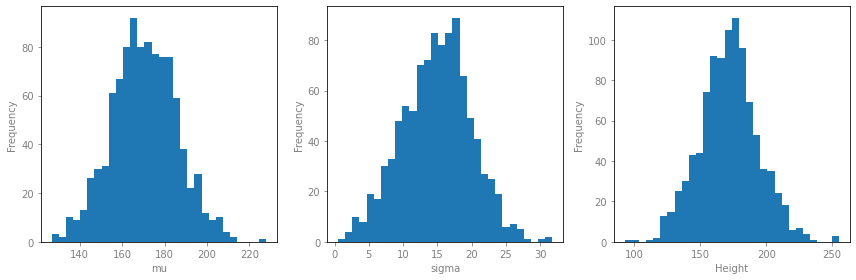

In [7]:
df_t1 = sim.draws_pd()
height_t1 = df_t1['height']
sigma_t1 = df_t1['sigma']
mu_t1 = df_t1['mu']
df_t1

# Plot histograms of mu, sigma, and height
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(mu_t1, bins=30)
axs[0].set_xlabel('mu', color='grey')
axs[1].hist(sigma_t1, bins=30)
axs[1].set_xlabel('sigma', color='grey')
axs[2].hist(height_t1, bins=30)
axs[2].set_xlabel('Height', color='grey')
for i in range(3):
    axs[i].set_ylabel('Frequency', color='grey')
    axs[i].tick_params(axis='both', colors='grey')
plt.tight_layout()
plt.show()

2. Plot a joint distribution of mu and sigma.

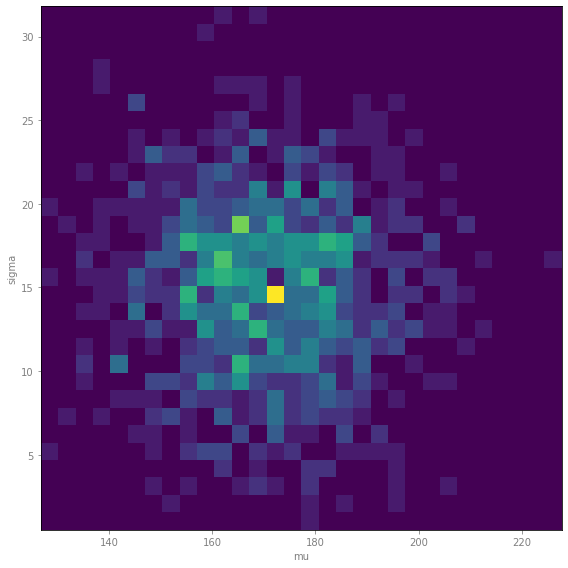

In [8]:
# Plot joint distribution of mu and sigma
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist2d(mu_t1, sigma_t1, bins=30)
ax.set_xlabel('mu', color='grey')
ax.set_ylabel('sigma', color='grey')
ax.tick_params(axis='both', colors='grey')
plt.tight_layout()
plt.show()

3. Check if samples are consistent with priors.

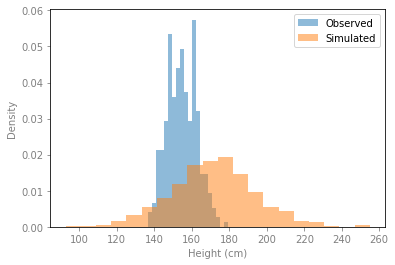

In [9]:
plt.hist(d.height.values, bins=20, density=True, alpha=0.5, label='Observed')
plt.hist(height_t1, bins=20, density=True, alpha=0.5, label='Simulated')
plt.tick_params(axis='both', colors='grey')
plt.xlabel('Height (cm)', color ='grey')
plt.ylabel('Density', color ='grey')
plt.legend()
plt.show()

Comment: Generated samples are not consisten with priors. Chosen mu and sigma seems to be too big and they need to be corrected.

4. Correct prior parameters to make them reasonably spreaded out.

INFO:cmdstanpy:compiling stan file /lab4/height_1_ppc.stan to exe file /lab4/height_1_ppc
INFO:cmdstanpy:compiled model executable: /lab4/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


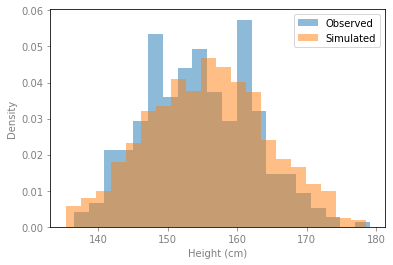

In [20]:
# generated quantities {
#   // First parameters:
# //   real mu = normal_rng(170, 15); // sample mean from normal distribution
# //   real sigma = normal_rng(15, 5); // sample standard deviation from normal distribution
# //   real height = normal_rng(mu, sigma); 
#   // Second parameters:
#   real <lower=0> mu = normal_rng(155, 8); // sample mean from normal distribution
#   real <lower=0> sigma = normal_rng(4, 1); // sample standard deviation from normal distribution
#   real <lower=135, upper=180> height = normal_rng(mu, sigma); 
  
# }
model_ppc=CmdStanModel(stan_file='lab4/height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)
                     
df_t1 = sim.draws_pd()
height_t1 = df_t1['height']
# For some reason block generates height = 0 (with used constraints) so I used this line of code to get rid of them:
height_t1 = height_t1[height_t1 > 0]

plt.hist(d.height.values, bins=20, density=True, alpha=0.5, label='Observed')
plt.hist(height_t1, bins=20, density=True, alpha=0.5, label='Simulated')
plt.tick_params(axis='both', colors='grey')
plt.xlabel('Height (cm)', color ='grey')
plt.ylabel('Density', color ='grey')
plt.legend()
plt.show()


5. Check if observed data is possible to obtain using priors.

Comment: Observed data is hard to obtain using normal distribution because it has got 3 peaks of density.

Task 2. Model fit and evaluation

In [22]:
model_1_fit=CmdStanModel(stan_file='lab4/height_1_fit.stan')
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Iteration: 1900 / 2000 [ 95%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


1. Plot a joint distribution of fitted mu and sigma.

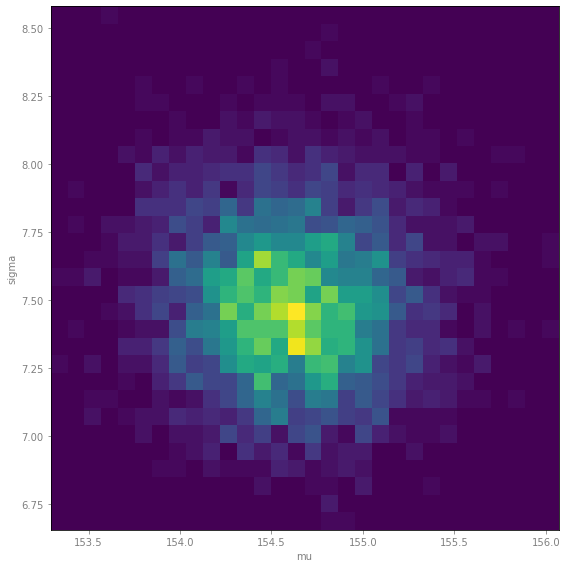

In [25]:
# Extract samples of mu, sigma and height
df_t2 = fit.draws_pd()
mu_t2 = df_t2['mu']
sigma_t2 = df_t2['sigma']
height_t2 = df['height_sim']

# Plot joint distribution of mu and sigma
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist2d(mu_t2, sigma_t2, bins=30)
ax.set_xlabel('mu', color='grey')
ax.set_ylabel('sigma', color='grey')
ax.tick_params(axis='both', colors='grey')
plt.tight_layout()
plt.show()

2. Plot histograms of data and simulated heights and evaluate the quality of model.

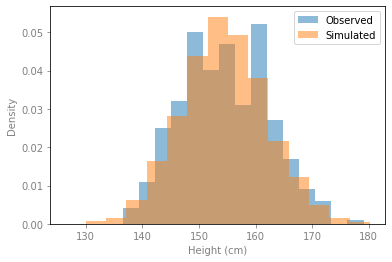

In [27]:
# Plot histograms of observed data and simulated height
plt.hist(d.height.values, bins=15, density=True, alpha=0.5, label='Observed')
plt.hist(height_t2, bins=15, density=True, alpha=0.5, label='Simulated')
plt.tick_params(axis='both', colors='grey')
plt.xlabel('Height (cm)', color ='grey')
plt.ylabel('Density', color ='grey')
plt.legend()
plt.show()

Task 3. Adding predictor to the model - weight

In [7]:
d['c_weight'] = d['weight'] - d['weight'].mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

Task 4. Prior predictive checks

In [11]:
model_ppc=CmdStanModel(stan_file='lab4/height_2a_ppc.stan')
R = 1000
sim_t4 = model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


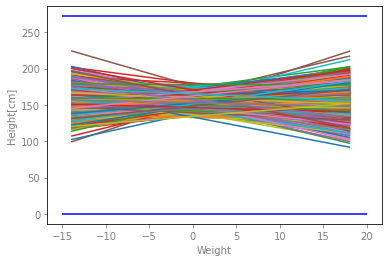

In [12]:
weight = np.linspace(d.c_weight.min(),d.c_weight.max())

# Extract samples of mu, sigma and height
df_t4 = sim_t4.draws_pd()
alpha_t4 = df_t4['alpha']
beta_t4 = df_t4['beta']
sigma_t4 = df_t4['sigma']

for i in range(len(alpha_t4)):
    y = alpha_t4[i] + beta_t4[i] * weight
    plt.plot(weight,y)
    
plt.hlines(0, xmin = - 15, xmax = 20,  color = 'b')
plt.hlines(272, xmin = - 15, xmax = 20,  color = 'b')
plt.ylabel('Height[cm]',  color = 'grey')
plt.xlabel('Weight',  color = 'grey')
plt.tick_params(axis='both', colors='grey')

Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.

In [19]:
model_ppc=CmdStanModel(stan_file='lab4/height_2b_ppc.stan')
sim_t5=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:compiling stan file /lab4/height_2b_ppc.stan to exe file /lab4/height_2b_ppc
INFO:cmdstanpy:compiled model executable: /lab4/height_2b_ppc
--- Translating Stan model to C++ code ---
bin/stanc  --o=/lab4/height_2b_ppc.hpp /lab4/height_2b_ppc.stan
Warning in '/lab4/height_2b_ppc.stan', line 3, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/lab4/height_2b_ppc.stan', line 11, column 2: Declaration of
    arrays by placing brackets after a variable name is deprecated and will
    be removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_


INFO:cmdstanpy:CmdStan done processing.


1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

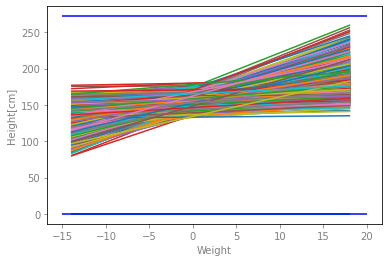

In [63]:
weight = np.linspace(d.c_weight.min(),d.c_weight.max())

# real beta=lognormal_rng(0, 1);

# Extract samples of mu, sigma and height
df_t5 = sim_t5.draws_pd()
alpha_t5 = df_t5['alpha']
beta_t5 = df_t5['beta']
sigma_t5 = df_t5['sigma']

for i in range(len(alpha_t5)):
    y = alpha_t5[i] + beta_t5[i] * weight
    plt.plot(weight,y)
    
plt.hlines(0, xmin = - 15, xmax = 20,  color = 'b')
plt.hlines(272, xmin = - 15, xmax = 20,  color = 'b')
plt.ylabel('Height[cm]',  color = 'grey')
plt.xlabel('Weight',  color = 'grey')
plt.tick_params(axis='both', colors='grey')

Beta no longer admits negative values but needs some aditional constraints to be consistent with predicted heights

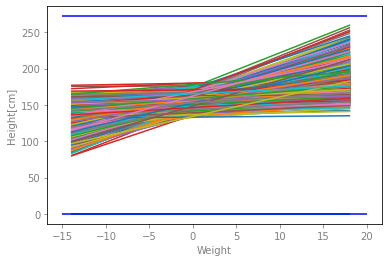

In [23]:
# Extract samples of mu, sigma and height
df_t5 = sim_t5.draws_pd()
alpha_t5 = df_t5['alpha']
beta_t5 = df_t5['beta']
sigma_t5 = df_t5['sigma']

for i in range(len(alpha_t5)):
    y = alpha_t5[i] + beta_t5[i] * weight
    plt.plot(weight,y)
    
plt.hlines(0, xmin = - 15, xmax = 20,  color = 'b')
plt.hlines(272, xmin = - 15, xmax = 20,  color = 'b')
plt.ylabel('Height[cm]',  color = 'grey')
plt.xlabel('Weight',  color = 'grey')
plt.tick_params(axis='both', colors='grey')

2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?


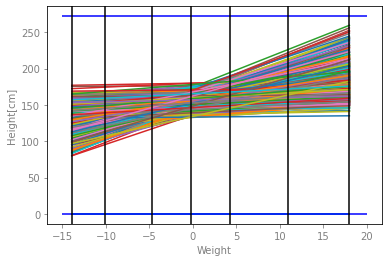

In [24]:
quant = d['c_weight'].quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

# Extract samples of mu, sigma and height
df_t5 = sim_t5.draws_pd()
alpha_t5 = df_t5['alpha']
beta_t5 = df_t5['beta']
sigma_t5 = df_t5['sigma']

for i in range(len(alpha_t5)):
    y = alpha_t5[i] + beta_t5[i] * weight
    plt.plot(weight,y)
    
plt.hlines(0, xmin = - 15, xmax = 20,  color = 'b')
plt.hlines(272, xmin = - 15, xmax = 20,  color = 'b')
plt.axvline(x=quant[0], color='k')
plt.axvline(x=quant[0.05], color='k')
plt.axvline(x=quant[0.25], color='k')
plt.axvline(x=quant[0.5], color='k')
plt.axvline(x=quant[0.75], color='k')
plt.axvline(x=quant[0.95], color='k')
plt.axvline(x=quant[1], color='k')
plt.ylabel('Height[cm]',  color = 'grey')
plt.xlabel('Weight',  color = 'grey')
plt.tick_params(axis='both', colors='grey')



Task 6. Fitting and evaluating model

In [8]:
model_2_fit=CmdStanModel(stan_file='lab4/height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create data_fit dictionary containing data from N first rows of dataframe

2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |███████▋  | 00:00 Iteration: 1400 / 2000 [ 70%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


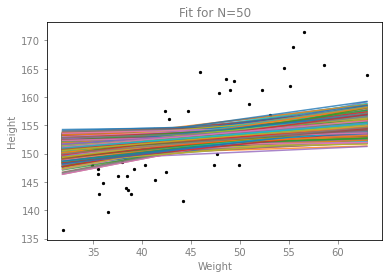

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)
chain 1 |█████████▌| 00:00 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


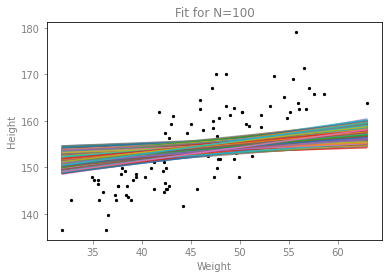

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)

chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


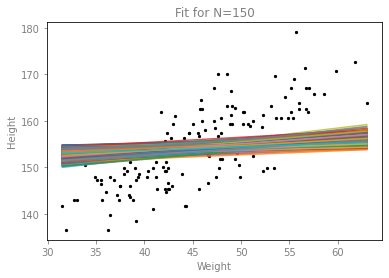

In [10]:
N_list = [50, 100, 150]

for i, N in enumerate(N_list):
    data_fit = {'N': N, 'heights': d['height'][:N].values, 'weight': np.linspace(d['weight'][:N].min(), d['weight'][:N].max(), N)}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df_t6 = fit.draws_pd()
    alpha_t6 = df_t6['alpha']
    beta_t6 = df_t6['beta']
    sigma_t6 = df_t6['sigma']
    height_pred = fit.stan_variable('height')

    plt.figure(i+1)
    for j in range(len(alpha_t6)):
        y = alpha_t6[j] + beta_t6[j] * data_fit['weight']
        plt.plot(data_fit['weight'], y, alpha=0.8)
    
    plt.scatter(d['weight'][:N], d['height'][:N], s=5, color='black')
    plt.xlabel('Weight', color = 'grey')
    plt.ylabel('Height', color = 'grey')
    plt.title(f'Fit for N={N}', color = 'grey')
    plt.tick_params(axis='both', colors='grey')
    plt.show()

3. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use errorbar from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


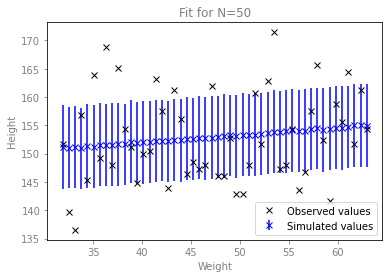

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████▍    | 00:00 Iteration: 1000 / 2000 [ 50%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |█████████ | 00:00 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


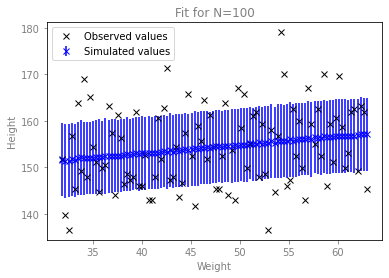

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 1 |██▋       | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       

INFO:cmdstanpy:CmdStan done processing.


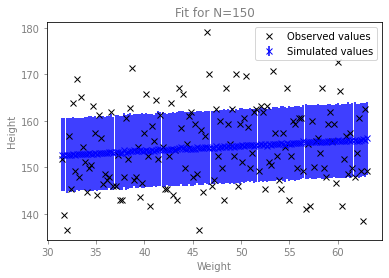

In [13]:
N_list = [50, 100, 150]

# Loop over the values of N and plot the figures
for i, N in enumerate(N_list):
    data_fit = {'N': N, 'heights': d['height'][:N].values, 'weight': np.linspace(d['weight'][:N].min(), d['weight'][:N].max(), N)}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    df_t6 = fit.draws_pd()
    alpha_t6 = df_t6['alpha']
    beta_t6 = df_t6['beta']
    sigma_t6 = df_t6['sigma']
    height_pred = fit.stan_variable('height')

    plt.figure(i+1)
    x=data_fit['weight']
    heights_mean = np.mean(fit.stan_variable('height'), axis=0)
    heights_std = np.std(fit.stan_variable('height'), axis=0)

    plt.errorbar(x, heights_mean, yerr=heights_std, fmt='x', color='b', label='Simulated values')
    plt.plot(x, data_fit['heights'], 'x', color='k', label='Observed values')
    plt.xlabel('Centered weight')
    plt.ylabel('Height[cm]')
    plt.xlabel('Weight', color = 'grey')
    plt.ylabel('Height', color = 'grey')
    plt.title(f'Fit for N={N}', color = 'grey')
    plt.tick_params(axis='both', colors='grey')
    plt.legend()
    plt.show()


Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of 
 in such case?

2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.

3. Try to vectorize the model to avoid necessity of a for loop in the model block.